In [147]:
%matplotlib notebook
from IPython.display import Image

import os
from glob import glob
from natsort import natsorted

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import matplotlib.animation as animation

In [148]:
import h5py
import torch
import numpy as np
from collections import OrderedDict

from sklearn import decomposition

from orthonet import jacob
from orthonet.models import SpritesVAE

## Quickly check out data

In [83]:
n_points = 1028

choice = np.random.choice(737280, size=n_points)
idx = np.zeros(737280, dtype=np.bool)
idx[choice] = True

BASE_PATH = '/u/xl/tjlane/cryoem/dynanet/particle_simulations/ortho/sprites/'

df = h5py.File(BASE_PATH + 'dsprites.h5', 'r')
original_data = np.array(df['imgs_shuffled'][idx,:,:]).astype(np.float32)
classes = np.array(df['latents/classes'])
values  = np.array(df['latents/values'])
df.close()

<IPython.core.display.Javascript object>


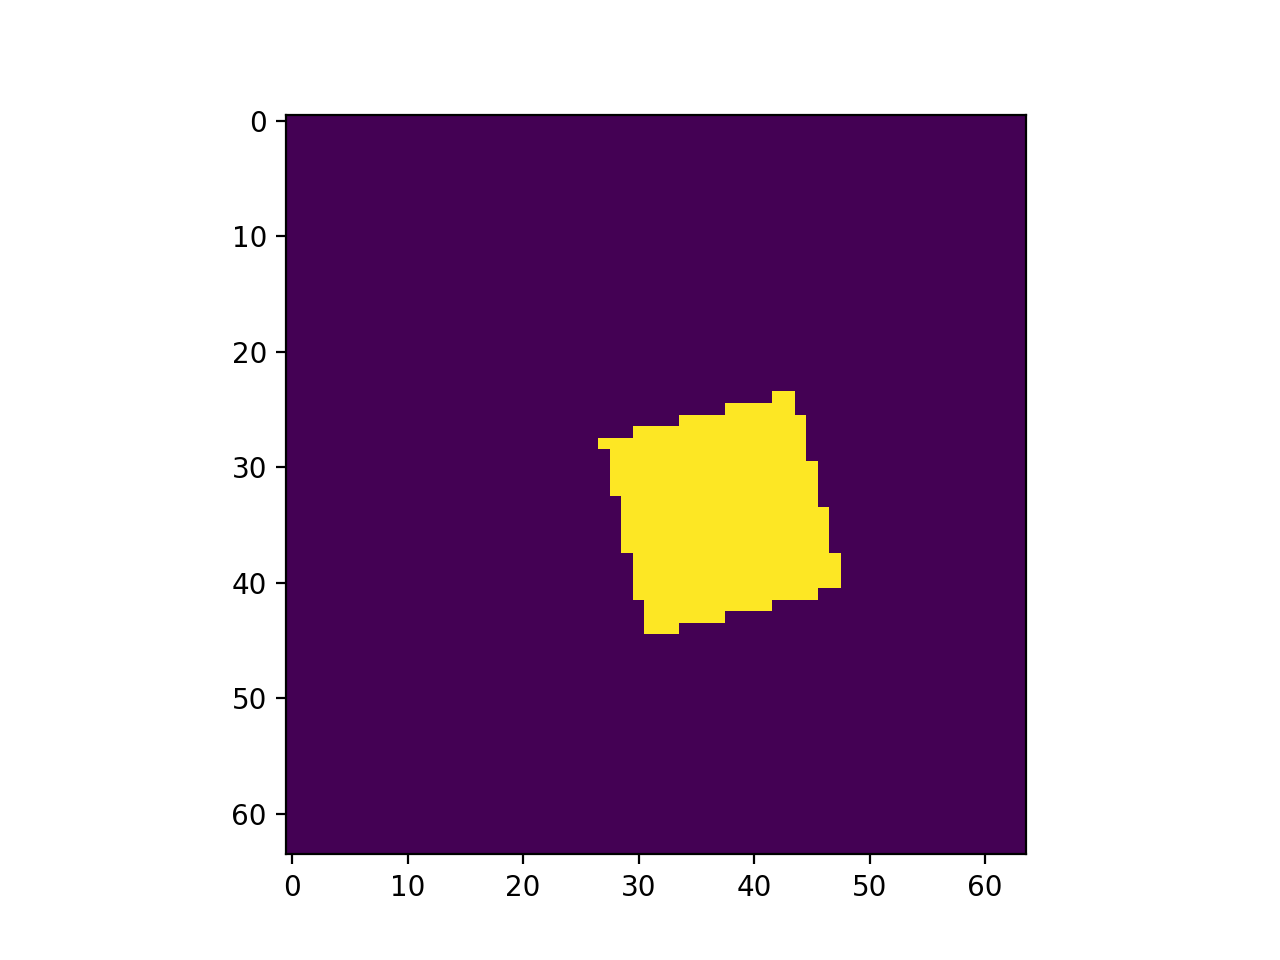

[ 0  0  1 10  5 15]
[1.         1.         0.6        1.61107316 0.16129032 0.48387097]


In [149]:
plt.figure()
plt.imshow(original_data[49])
plt.show()

img_shape = (64,64)

print(classes[choice[49]])
print(values[choice[49]])

### Load Data & Model

In [191]:
def strip_state_dict(state_dict):
    """
    Get rid of 'module.' prefix added by DataParallel
    """
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k.replace('module.', '')
        new_state_dict[name] = v
    return new_state_dict


def load_model(model_path, original_data):

    fn = model_path + '/model_dict.pt'
    if os.path.exists(fn):
        model = SpritesVAE(img_shape, latent_size, beta=vae_beta)
        sd = strip_state_dict(torch.load(fn))
        model.load_state_dict(sd)
        
        
    else:
        fns = natsorted( glob(model_path + '/checkpoints/model*pt') )
        if len(fns) > 0:
            print('Appears model did not complete, loading checkpoint:', fns[-1])
            model = torch.load(fns[-1]).cpu()
        else:
            print('could not find any models in:', model_path)
            return
            
    model.eval()
    
    ot = torch.tensor(original_data.astype(np.float32))
    latent = model.encode(ot).detach().numpy()
    recon  = model(ot)

    # deals with VAE case where I also saved logvar, use only mu here
    if type(recon) == tuple:
        recon = recon[0].detach().numpy()
    else:
        recon = recon.detach().numpy()

    return model, latent, recon


latent_size = 16
vae_beta    = 1.0
ort_beta    = 1e6


MODEL_PATH = BASE_PATH + 'ortho_spritesvae-%.2e_ob%.2e_db%.2e' % (vae_beta, ort_beta, 1.0)
model, latent, recon = load_model(MODEL_PATH, original_data)
model.eval()

SpritesVAE(
  (shared): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (13): BatchNorm

### Take a look at the training curves and direct latent space

torch.Size([8, 64, 64]) torch.Size([8, 64, 64])


<IPython.core.display.Javascript object>


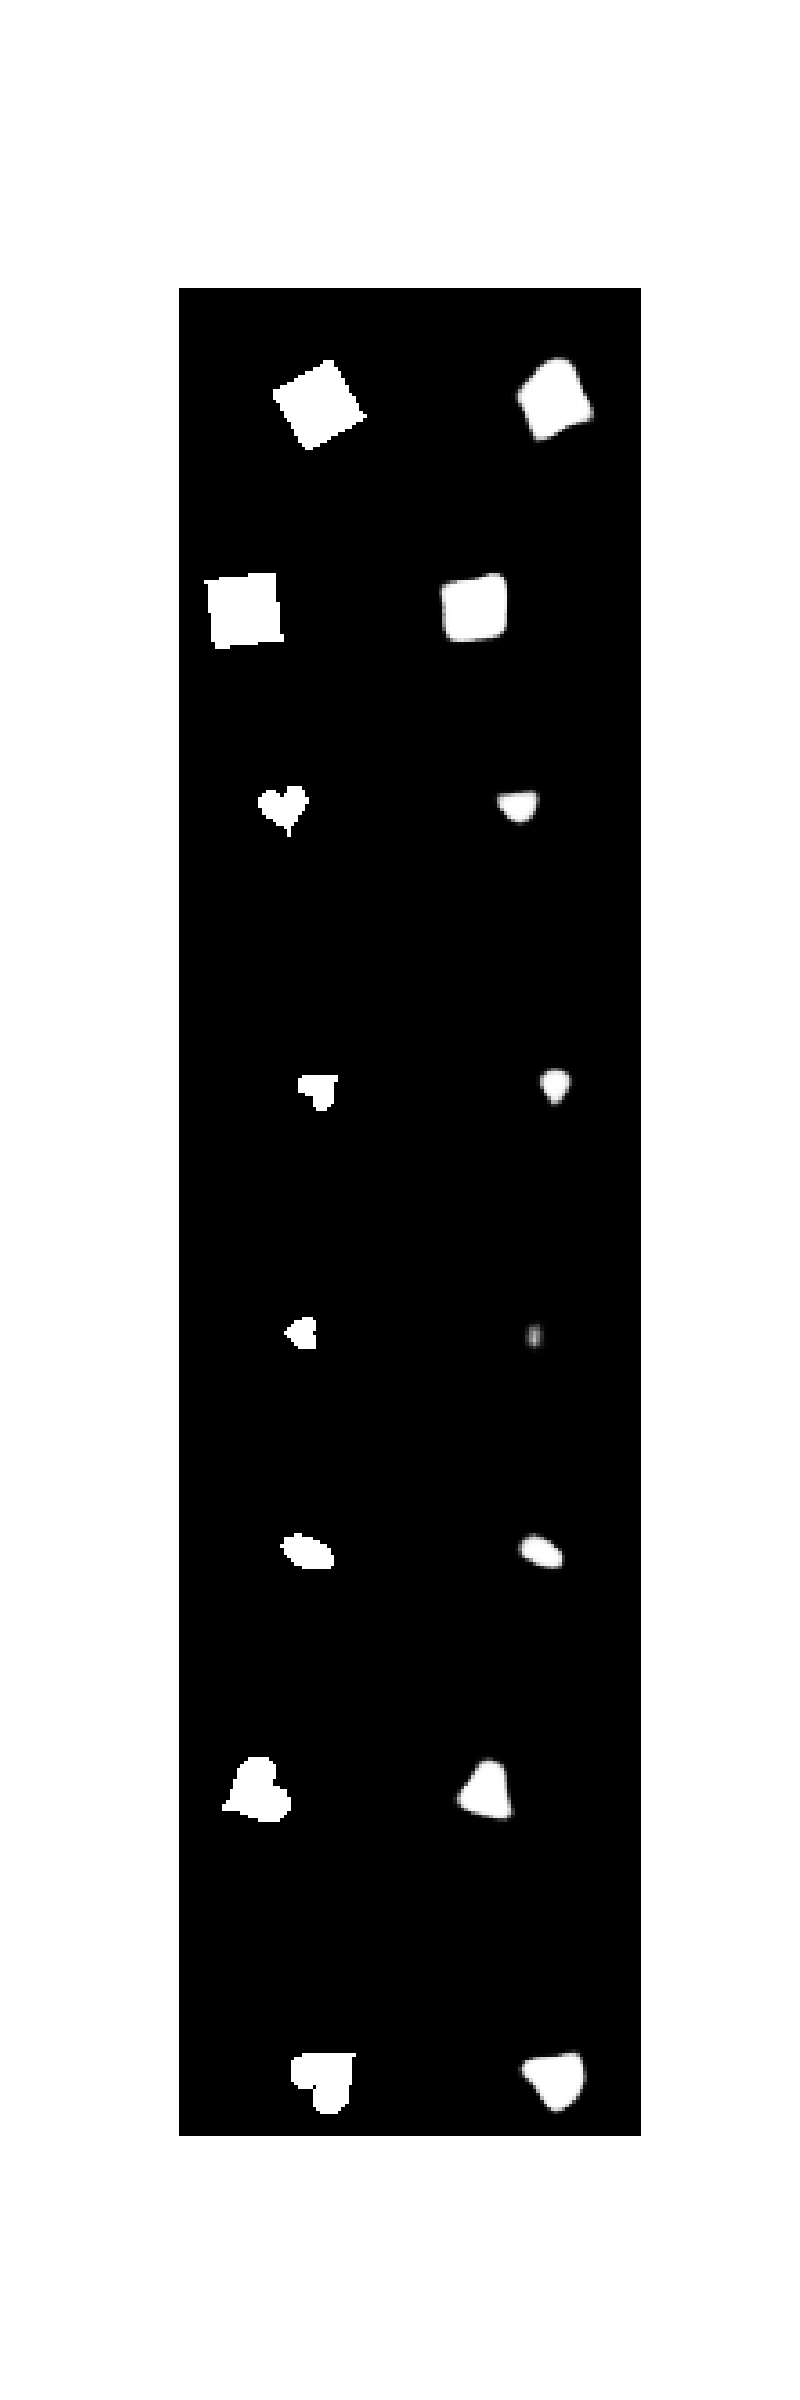

In [192]:
n_recon = 8

dps = torch.Tensor([ original_data[i*100] for i in range(n_recon) ])
recons = model( dps )

print(dps.size(), recons[0].size())

comps = []
for i in range(n_recon):
    comps.append( np.hstack( [ dps[i].detach().numpy(), recons[0][i].detach().numpy() ]) )

    
plt.figure(figsize=(4,12))
plt.imshow(np.vstack(comps), cmap='gray')
plt.axis('off')
plt.show()

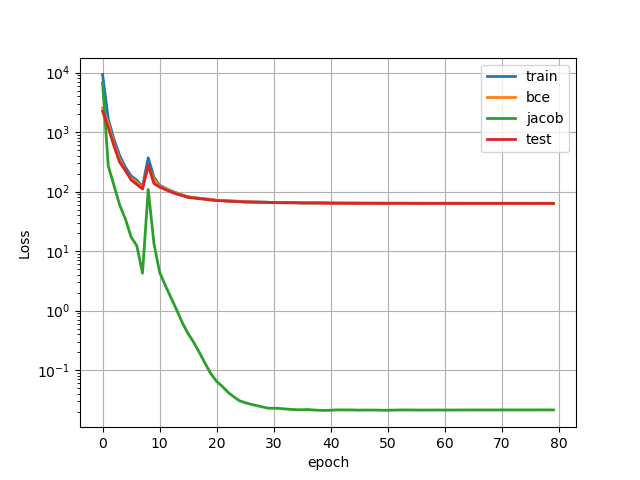

In [194]:
Image(filename=MODEL_PATH + '/loss_curves.png')

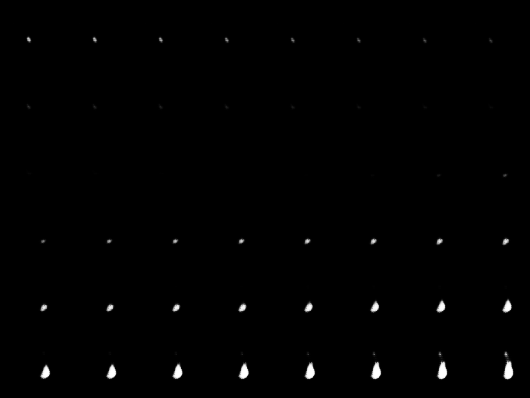

In [193]:
Image(filename=MODEL_PATH + '/z0.png')

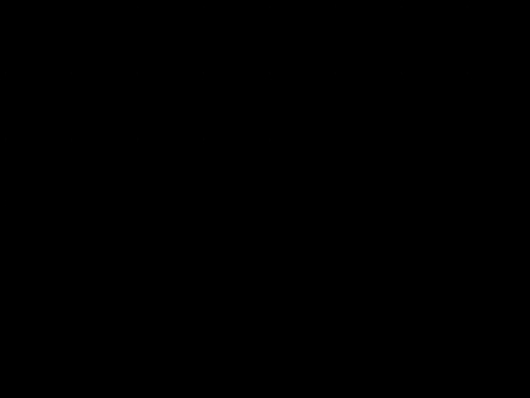

In [155]:
Image(filename=MODEL_PATH + '/z1.png')

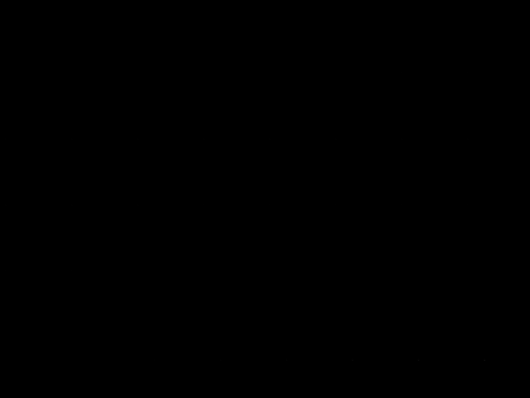

In [156]:
Image(filename=MODEL_PATH + '/z2.png')

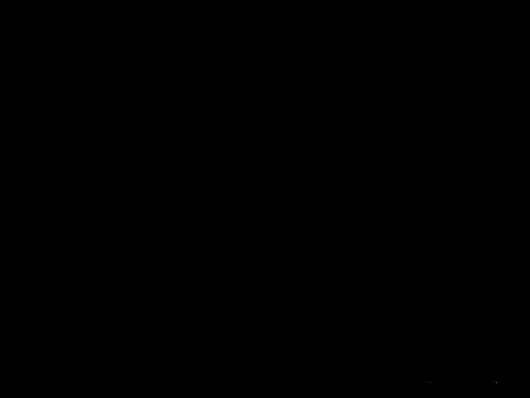

In [157]:
Image(filename=MODEL_PATH + '/z3.png')

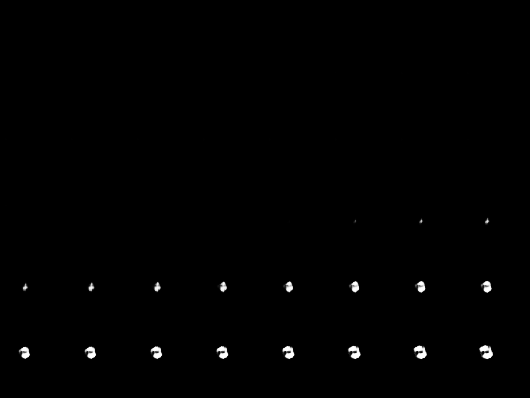

In [158]:
Image(filename=MODEL_PATH + '/z4.png')

### PCA Analysis of Latent Space

<IPython.core.display.Javascript object>


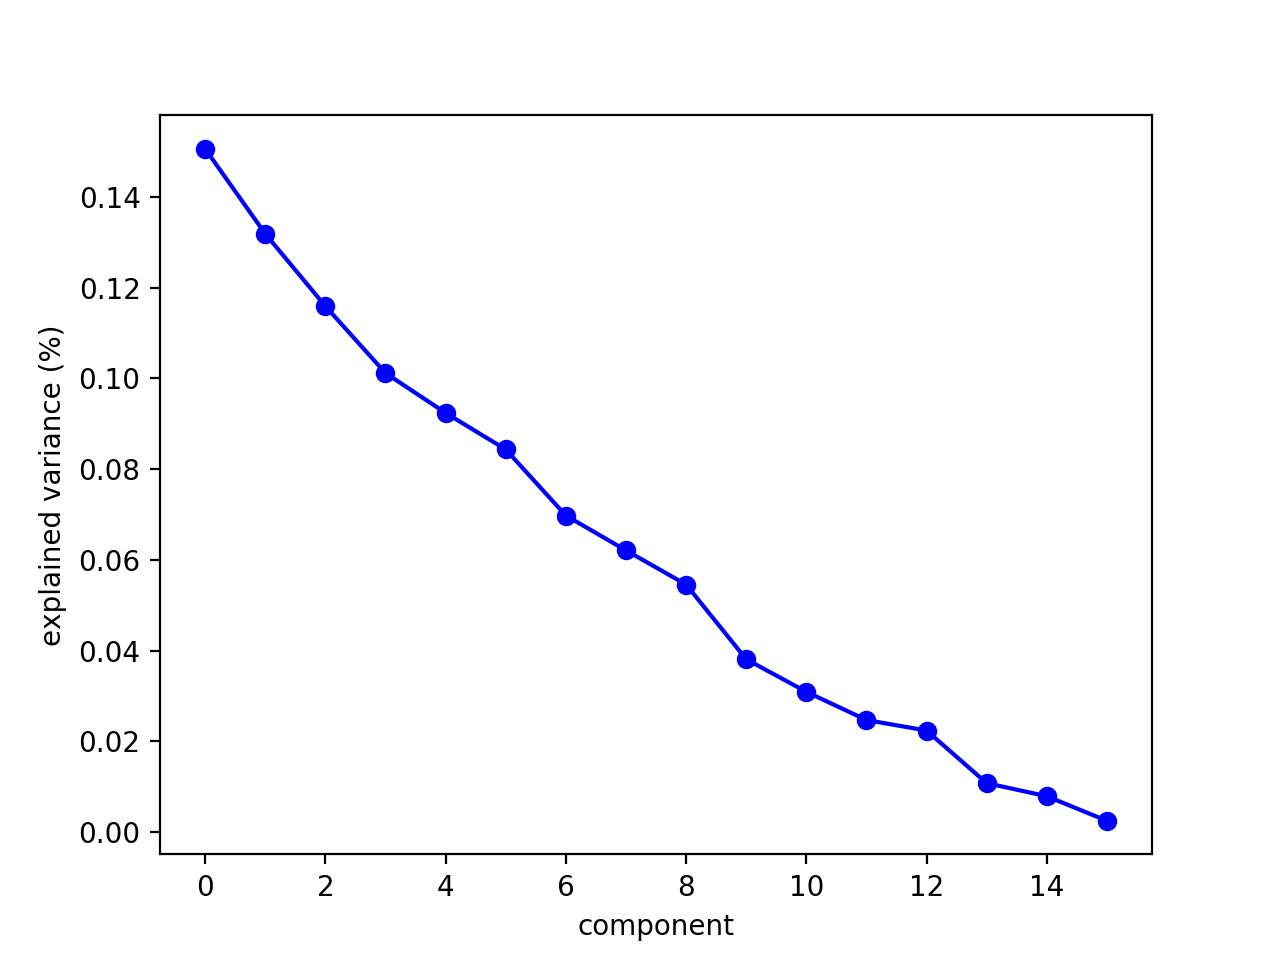

In [195]:
n_components = latent.shape[1]

pca = decomposition.PCA(n_components=n_components)
pca.fit(latent)

plt.figure()
plt.plot(pca.explained_variance_ratio_, 'bo')
plt.plot(pca.explained_variance_ratio_, 'b-')
plt.xlabel('component')
plt.ylabel('explained variance (%)')
plt.savefig(MODEL_PATH+'/pca_spectrum.pdf')
plt.show()

(1027, 16)


<IPython.core.display.Javascript object>


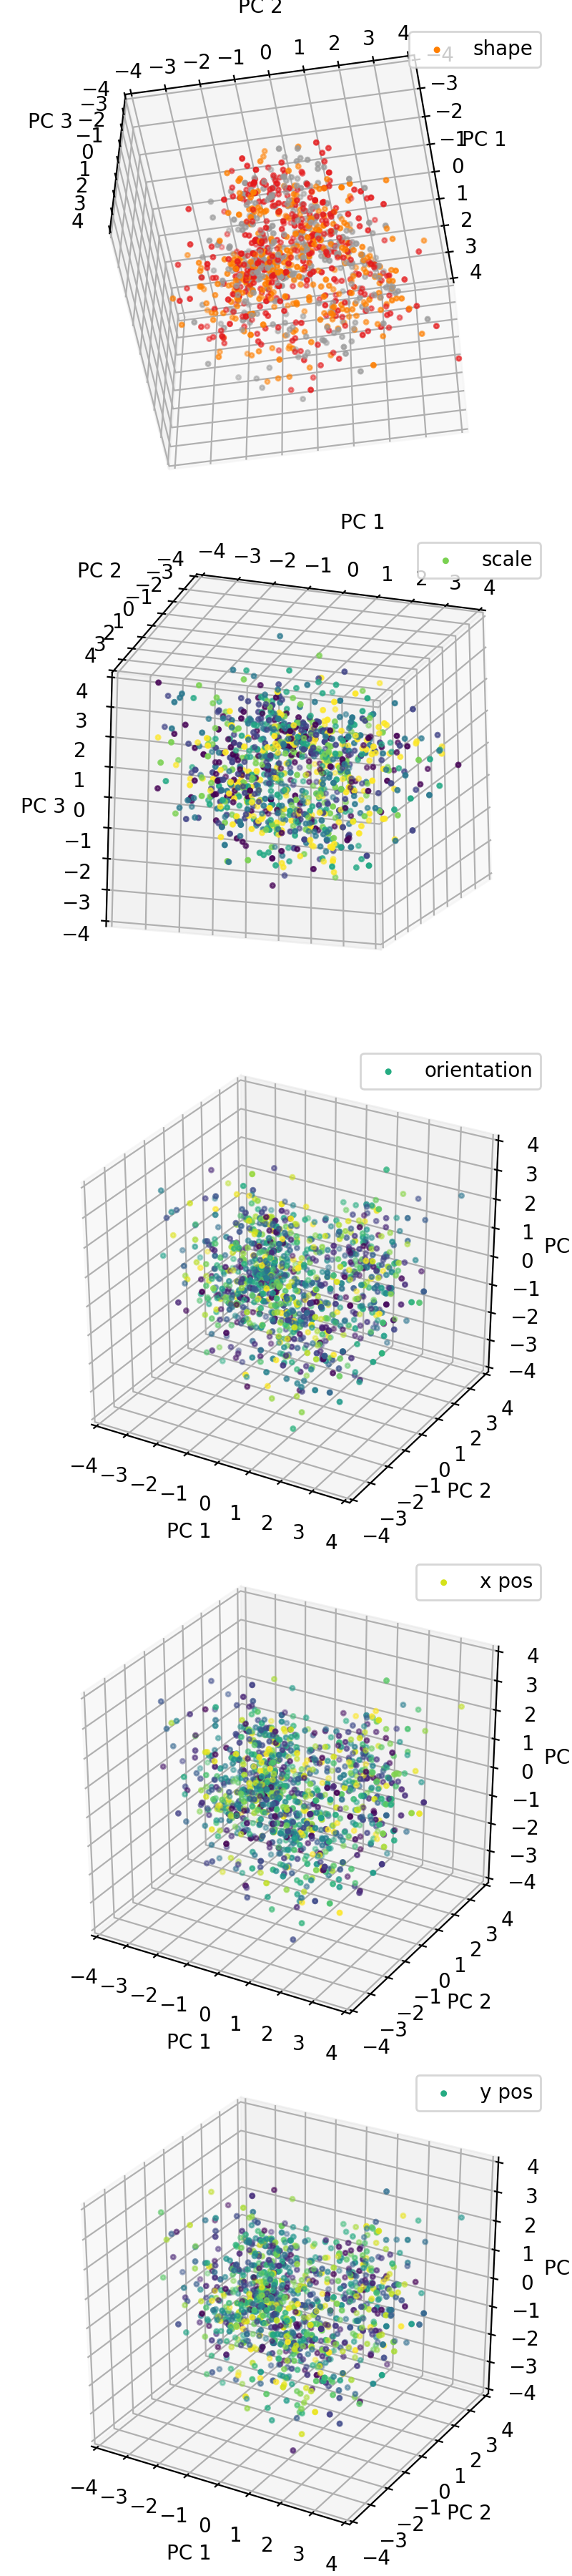

In [186]:
# latent factors
#     Color: white
#     Shape: square, ellipse, heart
#     Scale: 6 values linearly spaced in [0.5, 1]
#     Orientation: 40 values in [0, 2 pi]
#     Position X: 32 values in [0, 1]
#     Position Y: 32 values in [0, 1]



max_pts = 1024
class_idx = 2
l = 4 # plot limits

latent_in_pc = pca.transform(latent)
print(latent_in_pc.shape)

fig = plt.figure(figsize=(4,18))

# ----------------------------------------

class_idx  = [1,2,3,4,5]
class_name = ['shape', 'scale', 'orientation', 'x pos', 'y pos']
cmaps      = [plt.cm.Set1, plt.cm.viridis, plt.cm.viridis, plt.cm.viridis, plt.cm.viridis]

# ----------------------------------------

for ci in range(len(class_idx)):
    
    ax = fig.add_subplot(len(class_idx), 1, ci+1, projection='3d')

    ax.scatter(latent_in_pc[:max_pts,0],
               latent_in_pc[:max_pts,1],
               latent_in_pc[:max_pts,2],
               c=values[choice[:max_pts],class_idx[ci]],
               cmap=cmaps[ci], marker='.')

    ax.set_xlabel('PC 1')
    ax.set_ylabel('PC 2')
    ax.set_zlabel('PC 3')
    ax.legend([class_name[ci]])

    ax.set_xlim([-l,l])
    ax.set_ylim([-l,l])
    ax.set_zlim([-l,l])

plt.tight_layout()
plt.savefig(MODEL_PATH+'/latent.pdf')
plt.show()

### Direct look at the Jacobian of the resulting network

In [161]:
n_samples = 128
n_outputs = torch.tensor(np.product(original_data.shape[1:]))

J = np.zeros([64*64, latent.shape[1]])
for i in range(n_samples):
    Jx = jacob.jacobian(model.decode, torch.tensor(latent[i]), n_outputs)
    J += Jx.detach().numpy()

<IPython.core.display.Javascript object>


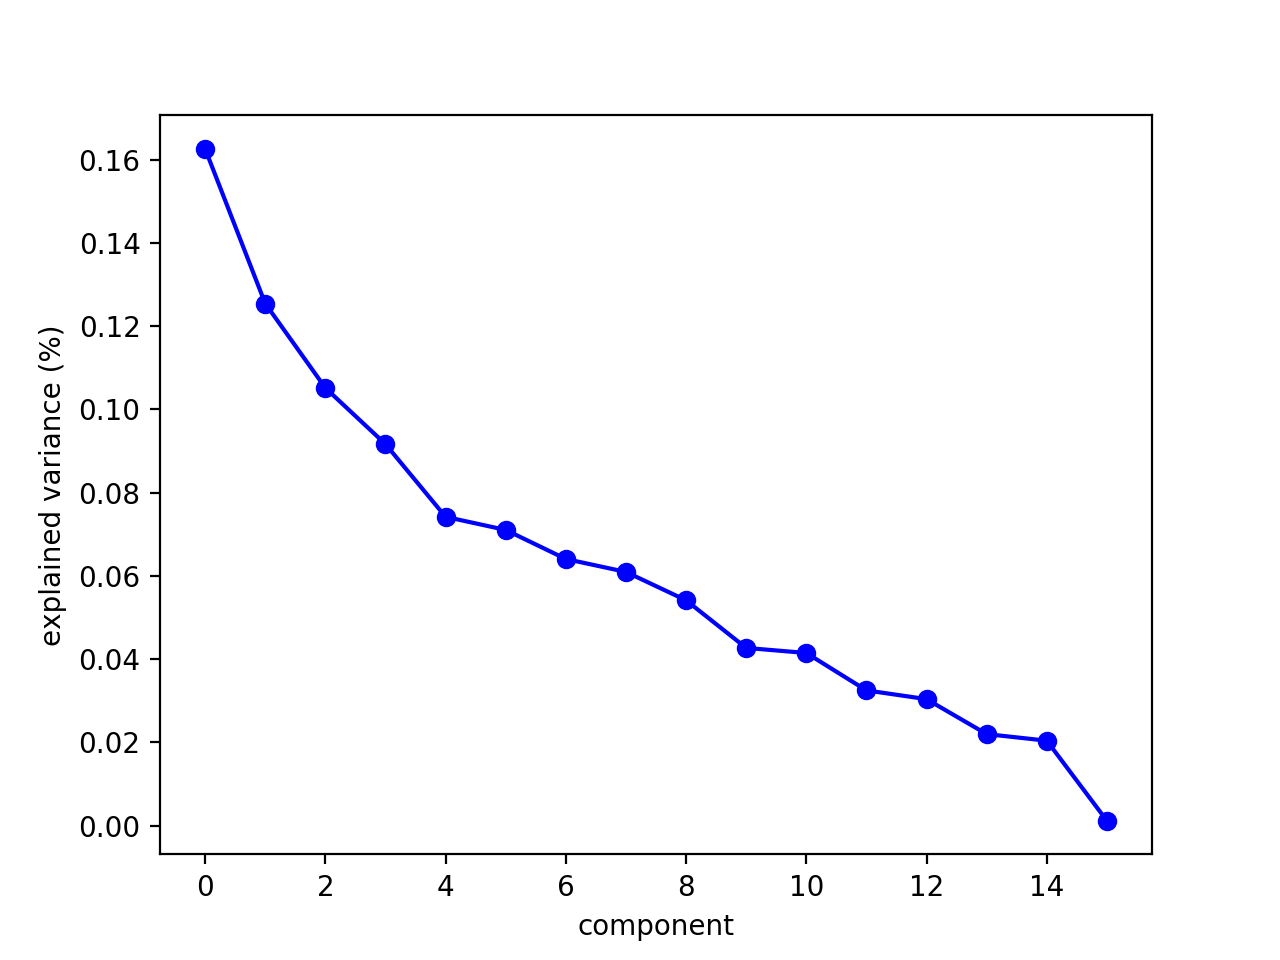

In [162]:
J_pca = decomposition.PCA(n_components=J.shape[1])
J_pca.fit(J)

plt.figure()
plt.plot(J_pca.explained_variance_ratio_, 'bo')
plt.plot(J_pca.explained_variance_ratio_, 'b-')
plt.xlabel('component')
plt.ylabel('explained variance (%)')
plt.savefig(MODEL_PATH+'/pca_spectrum.pdf')
plt.show()

<IPython.core.display.Javascript object>


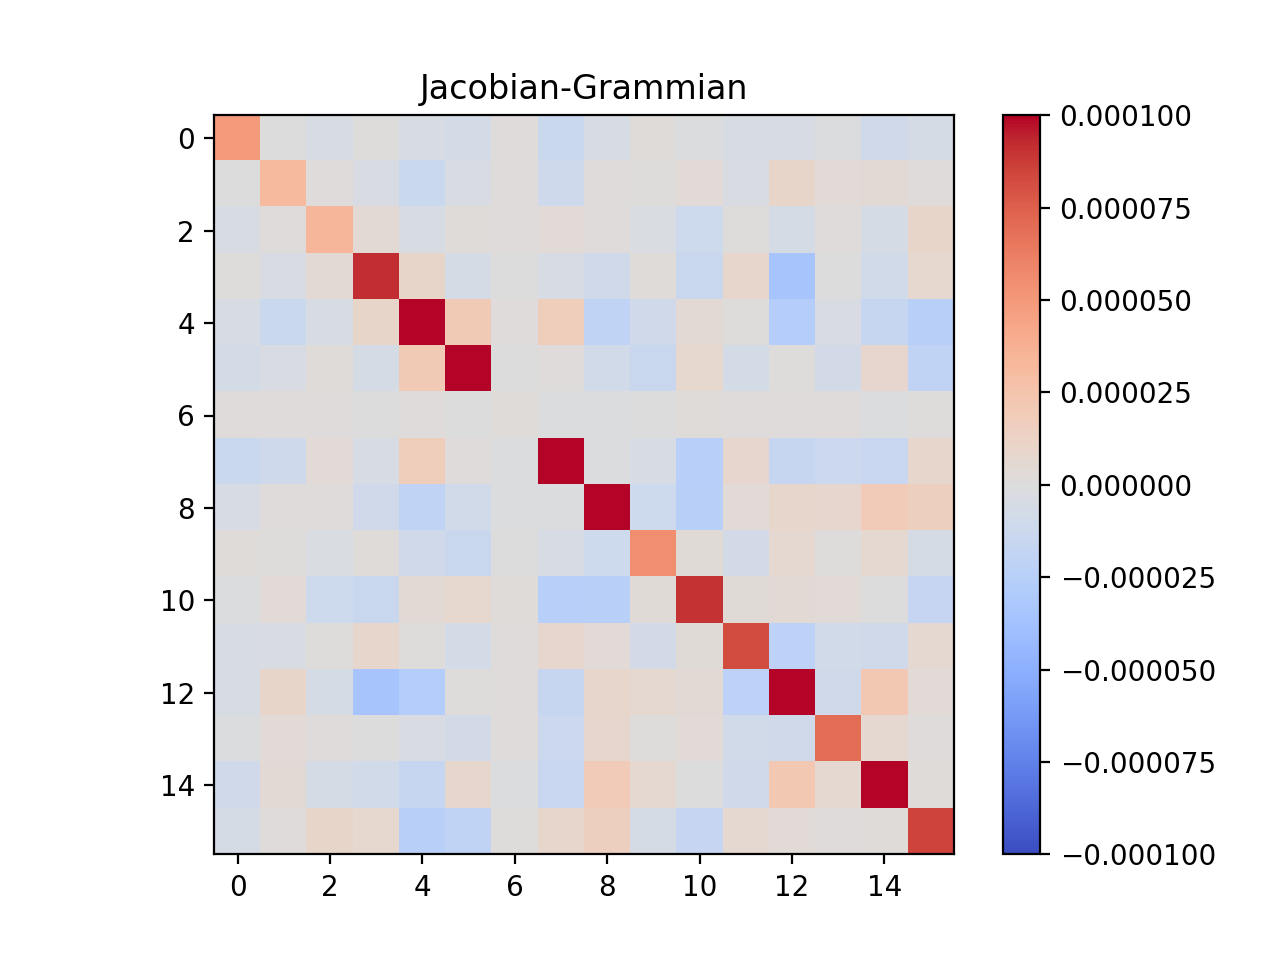

In [164]:
scale = 1e-4

JG = np.dot(J.T, J)

plt.figure()
plt.title('Jacobian-Grammian')
plt.imshow(JG, cmap='coolwarm', vmin=-scale, vmax=scale)

# for (j,i),label in np.ndenumerate(JG):
#     plt.text(i, j, np.round(label,2), ha='center', va='center', color='w')

plt.colorbar()
    
plt.show()

<IPython.core.display.Javascript object>


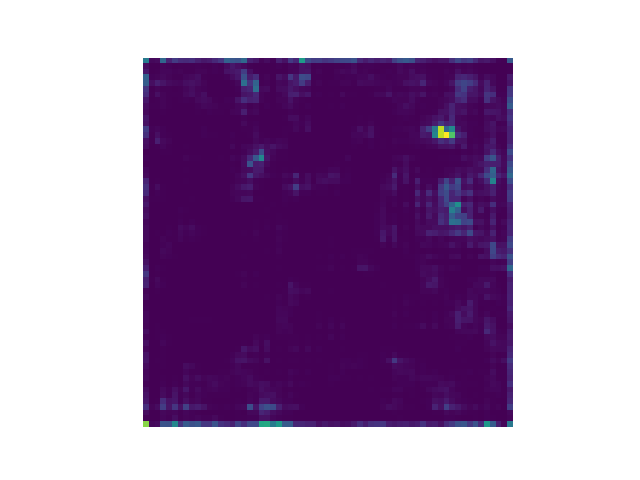

In [138]:
# trace out the PC space

model.eval()

lim = 3 # 2
res = 0.02 # 0.05
fps = 60

basis = 'pcs'
#basis = 'latent'

component = 2

if basis == 'pcs':
    z = pca.components_[component]
elif basis == 'latent':
    z = np.eye(n_components)[component]

s = np.arange(-lim,lim,res)
z = np.outer(s, z)

# offset

z = z + np.random.randn(n_components)[None,:]


rx = model.decode( torch.tensor(z.astype(np.float32)) ).detach().numpy()


fig = plt.figure()
ax = plt.subplot(111)
ax.axis('off')
ims = []
for ii,ri in enumerate(rx):
    #ax.title(s[ii])
    ims.append( [plt.imshow(ri, animated=True)] )
ani = animation.ArtistAnimation(fig, ims, interval=fps, blit=False,
                                repeat_delay=0)
ani.save('/u/xl/tjlane/%s_%d_movie.mp4' % (basis, component), 
        fps=fps)
plt.show()